In [1]:
import math
from scipy.integrate import quad, fixed_quad
import matplotlib.pyplot as plt
import pickle 
import numpy as np
import functools
import sys 
ρcrit0 = 2.77533742639e+11 #h^2 Msol / Mpc^3
cosmo_params = pickle.load(open('data/cosmo_params.pkl', 'rb'))

In [2]:
def log_likelihood(param_values):
    lp = log_prior(param_values)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_prob(param_values)

In [3]:
param_names = [ 'd1','e0' ,'e1','f0', 'g0','g1']

FIXED = {
         'f1':0.12,
         'd0':2.4,
        }

In [4]:
from os.path import exists
params = {}


ndim = len(param_names)
for box in cosmo_params:
    if('Box5_1400' in box): #something weird going on
        continue
    #check if there is a fit for this box by checking if the corresponding figure exsits
    fig_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/figures/%s_fit_%.2f.pdf'%(box, 1.0)
    if(not exists(fig_fname)):
        print('Skipping %s'%(box))
        continue
    sampler = None
    with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_MCMC_sampler.pkl"%(box), "rb") as f:
        sampler = pickle.load(f)
    samples = sampler.chain[:, 4000:, :].reshape((-1, ndim))
    final_param_vals = np.percentile(samples,  50,axis=0)
    params[box] = dict(zip(param_names, final_param_vals))

Skipping Box12_1400
Skipping Box15_1400
Skipping Box21_1400
Skipping Box22_1400
Skipping Box35_1400
Skipping Box36_1400
Skipping Box47_1400
Skipping Box49_1400
Skipping Box52_1400
Skipping Box54_1400
Skipping Box63_1400
Skipping Box70_1400
Skipping Box82_1400
Skipping Box85_1400
Skipping Box95_1400


In [5]:
def train_test_split(length, split=0.7):
    indices = np.random.permutation(length)
    split_len = int(length*split)
    return indices[:split_len], indices[split_len:]

In [6]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

In [109]:
X, Y = [], []
for box in params:
    X += [list(cosmo_params[box].values())]
    Y += [list(params[box].values())]
X = np.array(X)
Y = np.array(Y)

training_idx, testing_idx = train_test_split(len(X), split=0.9)
X_train, X_test = X[training_idx], X[testing_idx]
Y_train, Y_test = Y[training_idx], Y[testing_idx]

box_train = np.array(list(params.keys()))[training_idx]
box_test = np.array(list(params.keys()))[testing_idx]

Since $K_X$ is positive semi-definite and symmetric we can diagonlize
$$K_X = R \Lambda R^T$$
Where $\Lambda$ are eigenvalues and $R$ are eigenvectors

For some $Y= H X$ we have $K_Y = H K_X H^T$. If we choose $H = R^T$ we have
$$K_Y = R^T K_X R = R^T R \Lambda R^T R = \Lambda$$
Lets define
$$\frac 1 {\sqrt\Lambda} = \rm{diag}(1/\sqrt{\lambda_1},\dots)$$
And thus we have diagonlized. We can go further though by choosing $H = \frac{1}{\sqrt{ \Lambda }} R^T$ meaning
$$K_Y = \frac{1}{\sqrt{ \Lambda }} \Lambda  \frac{1}{\sqrt{ \Lambda }} = \mathbb I$$
We also see that 
$$H^{-1} Y = X$$

In [110]:
import numpy as np

def is_nearly_identity(matrix, tolerance=1e-6):
    """
    Check if a matrix is nearly the identity matrix.
    
    Arguments:
    matrix -- a 2D numpy array representing the matrix
    tolerance -- the allowed tolerance for the non-identity elements
    
    Returns:
    True if the matrix is nearly the identity matrix, False otherwise
    """
    rows, cols = matrix.shape
    
    # Check if the matrix is square
    if rows != cols:
        return False
    
    # Check if diagonal elements are close to 1
    if not np.allclose(np.diag(matrix), 1.0, atol=tolerance):
        return False
    
    # Check if off-diagonal elements are close to 0
    off_diagonal = matrix[~np.eye(rows, dtype=bool)]
    if not np.allclose(off_diagonal, 0.0, atol=tolerance):
        return False
    
    return True


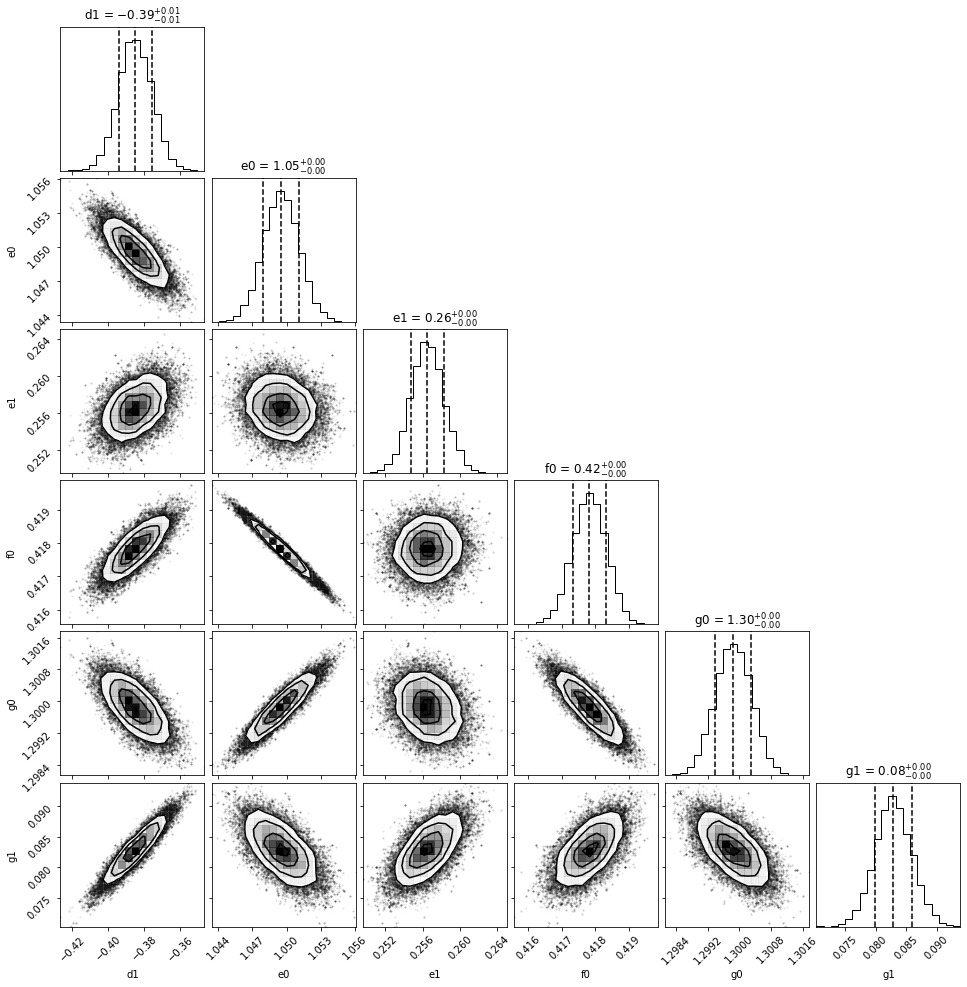

In [111]:
central_box = 'Box_n50_0_1400' 
sampler = None
with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_MCMC_sampler.pkl"%(central_box), "rb") as f:
    sampler = pickle.load(f)
    
import corner
samples = sampler.chain[:, 4000:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=param_names, quantiles=[0.16, 0.5, 0.84],show_titles=True,)

In [112]:
# Get the chain samples
samples = sampler.get_chain(flat=True, discard=1000)

# Compute the covariance matrix and mean
cov = np.cov(samples.T) 
μ = np.mean(samples, axis=0)

# Get the eigendecomposition of the covariance matrix
eigvals, eigvecs = np.linalg.eigh(cov)

# Get the rotation matrix
rot_matrix = np.diag(1/np.sqrt(eigvals))@eigvecs.T

rotated_cov = rot_matrix@cov@rot_matrix.T
is_nearly_identity(rotated_cov)

True

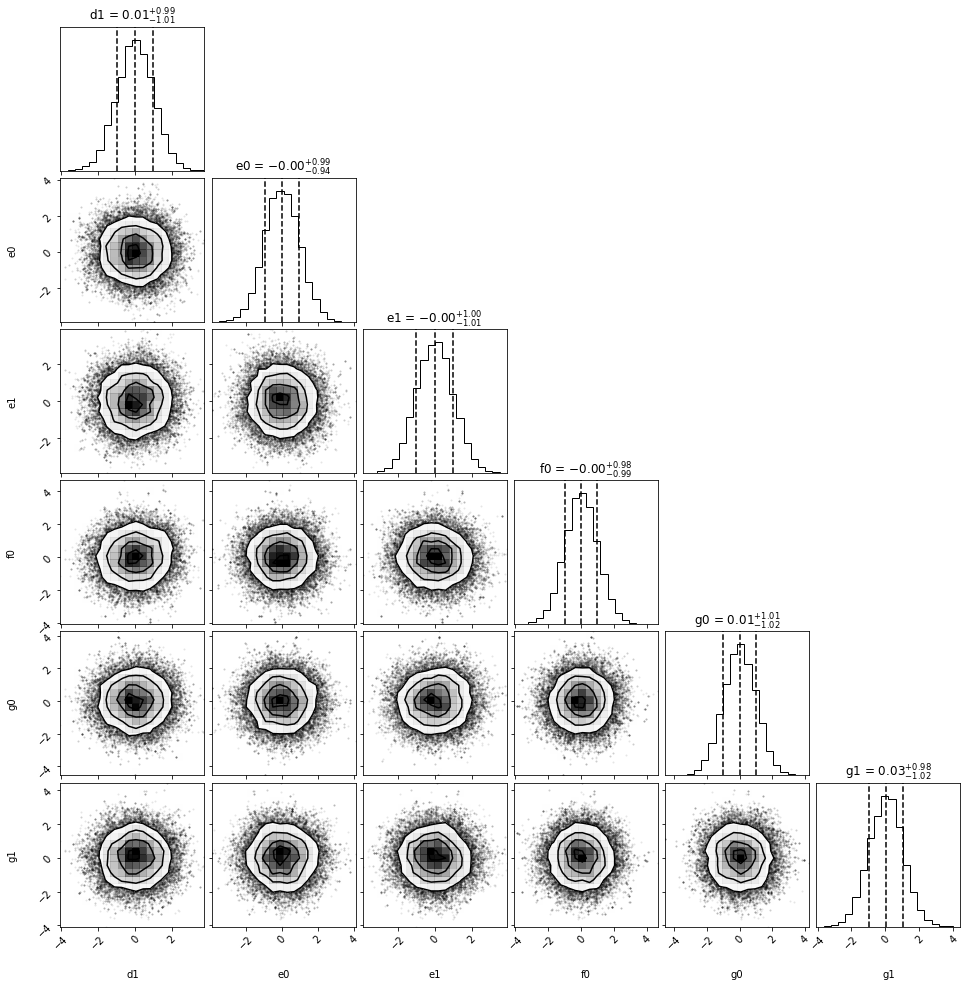

In [113]:
import corner
samples = (sampler.chain[:, 4000:, :].reshape((-1, ndim)) - μ).T
fig = corner.corner((rot_matrix@samples).T, labels=param_names, quantiles=[0.16, 0.5, 0.84],show_titles=True,)

In [114]:
def get_whitener(box):
    sampler = None
    with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_MCMC_sampler.pkl"%(box), "rb") as f:
        sampler = pickle.load(f)
    # Get the chain samples
    samples = sampler.get_chain(flat=True, discard=1000)

    # Compute the covariance matrix and mean
    cov = np.cov(samples.T) 
    μ = np.mean(samples, axis=0)

    # Get the eigendecomposition of the covariance matrix
    eigvals, eigvecs = np.linalg.eigh(cov)

    # Get the rotation matrix
    rot_matrix = np.diag(1/np.sqrt(eigvals))@eigvecs.T

    rotated_cov = rot_matrix@cov@rot_matrix.T
    assert(is_nearly_identity(rotated_cov))
    return μ, rot_matrix

In [115]:
from tqdm import tqdm
μs = []
rot_matrixs = []
for box in tqdm(box_train):
    μ, rot_matrix = get_whitener(box)
    if(len(μs)==0):
        μs = [μ]
        rot_matrixs = [rot_matrix]
    else:
        μs = np.vstack([μs, [μ]])
        rot_matrixs = np.vstack([rot_matrixs, [rot_matrix]])

100%|██████████| 120/120 [00:02<00:00, 49.84it/s]


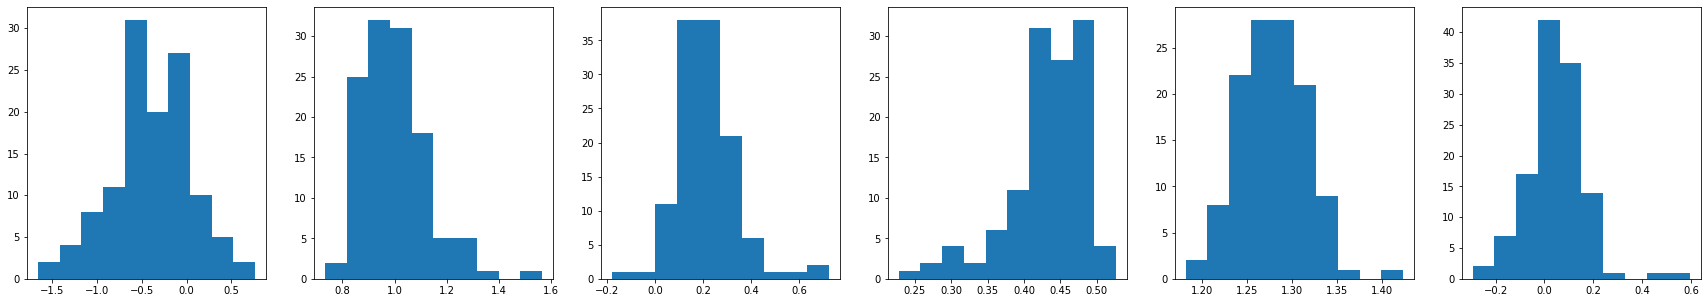

In [116]:
fig, axs = plt.subplots(ncols=μs.shape[1], figsize=(30,5))
for i, ax in enumerate(axs):
    ax.hist(μs.T[i])

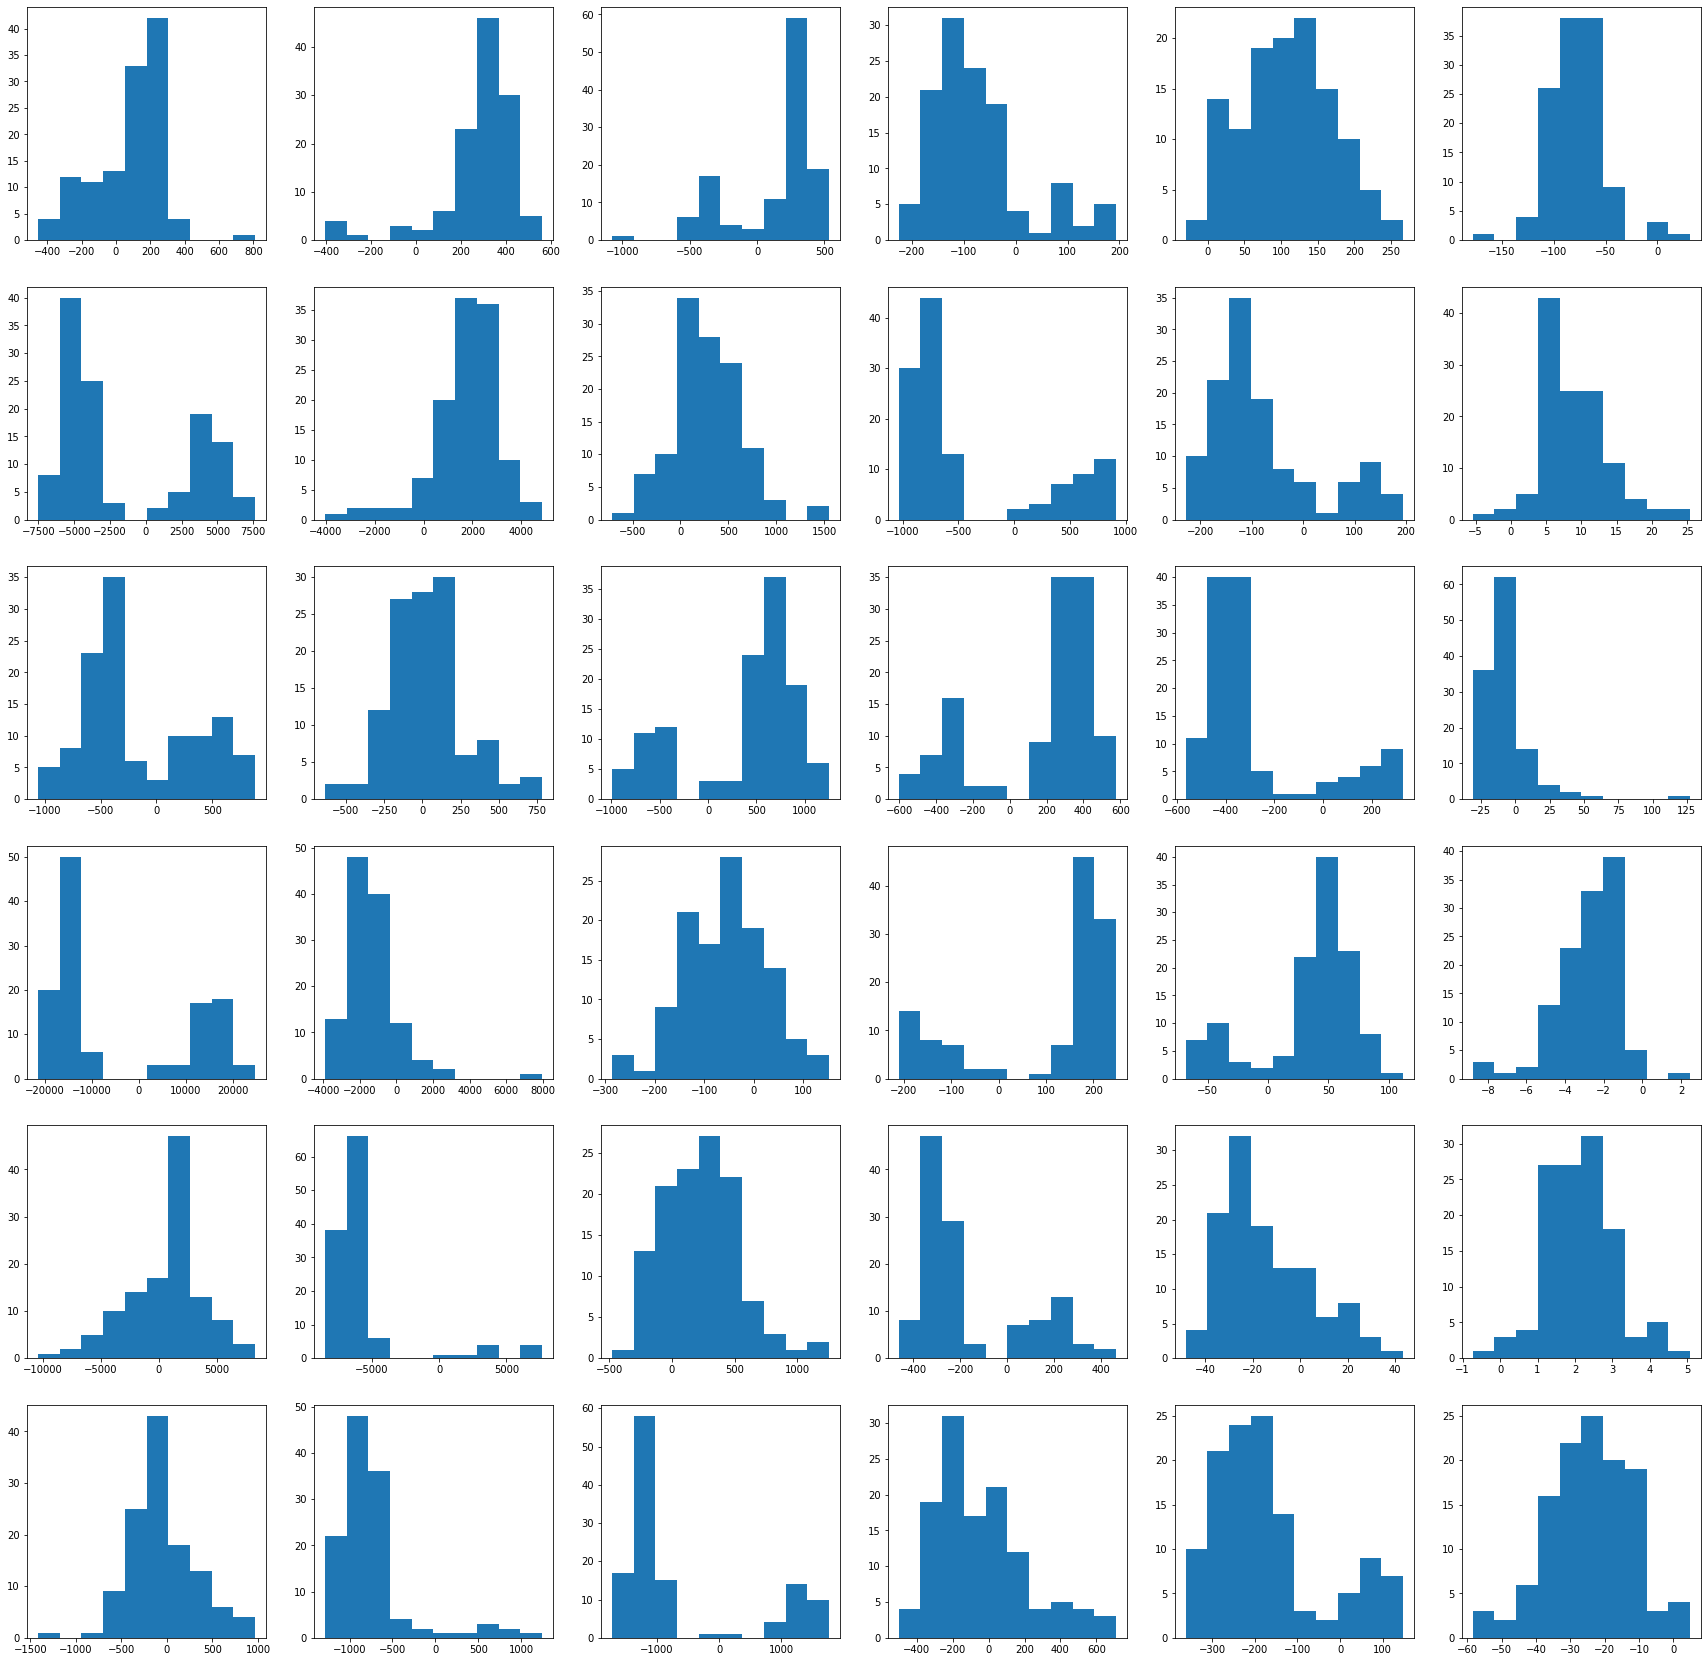

In [117]:
fig, axs = plt.subplots(ncols=rot_matrixs.shape[1], nrows=rot_matrixs.shape[2], figsize=(30,30))
for i in range(rot_matrixs.shape[1]):
    for j in range(rot_matrixs.shape[2]):
        axs[i][j].hist(rot_matrixs.T[i][j])

In [118]:
μ, rot_matrix = get_whitener('Box_n50_0_1400')
Yp_train = (rot_matrix@(Y_train-μ).T).T
Yp_test = (rot_matrix@(Y_test-μ).T).T

In [119]:
X_train, X_test = torch.from_numpy(X_train).float(), torch.from_numpy(X_test).float()
Yp_train, Yp_test = torch.from_numpy(Yp_train).float(), torch.from_numpy(Yp_test).float()

n_tasks = len(Y_train[0])

In [120]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=n_tasks
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=X_train.shape[1]), num_tasks=n_tasks, rank=1
        )
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=n_tasks)
model = MultitaskGPModel(X_train, Yp_train, likelihood)

In [121]:
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [122]:
training_iterations = 3000
for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(X_train)
    loss = -mll(output, Yp_train)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

Iter 1/3000 - Loss: 5806.730
Iter 2/3000 - Loss: 5136.779
Iter 3/3000 - Loss: 4535.213
Iter 4/3000 - Loss: 4004.148
Iter 5/3000 - Loss: 3544.432
Iter 6/3000 - Loss: 3154.264
Iter 7/3000 - Loss: 2828.562
Iter 8/3000 - Loss: 2559.654
Iter 9/3000 - Loss: 2339.012
Iter 10/3000 - Loss: 2158.310
Iter 11/3000 - Loss: 2009.918
Iter 12/3000 - Loss: 1887.119
Iter 13/3000 - Loss: 1784.176
Iter 14/3000 - Loss: 1696.471
Iter 15/3000 - Loss: 1620.402
Iter 16/3000 - Loss: 1553.264
Iter 17/3000 - Loss: 1493.073
Iter 18/3000 - Loss: 1438.431
Iter 19/3000 - Loss: 1388.291
Iter 20/3000 - Loss: 1341.965
Iter 21/3000 - Loss: 1298.969
Iter 22/3000 - Loss: 1258.901
Iter 23/3000 - Loss: 1221.472
Iter 24/3000 - Loss: 1186.504
Iter 25/3000 - Loss: 1153.815
Iter 26/3000 - Loss: 1123.183
Iter 27/3000 - Loss: 1094.551
Iter 28/3000 - Loss: 1067.756
Iter 29/3000 - Loss: 1042.680
Iter 30/3000 - Loss: 1019.212
Iter 31/3000 - Loss: 997.227
Iter 32/3000 - Loss: 976.649
Iter 33/3000 - Loss: 957.353
Iter 34/3000 - Loss: 9

Iter 283/3000 - Loss: 273.598
Iter 284/3000 - Loss: 273.030
Iter 285/3000 - Loss: 272.466
Iter 286/3000 - Loss: 271.903
Iter 287/3000 - Loss: 271.342
Iter 288/3000 - Loss: 270.784
Iter 289/3000 - Loss: 270.231
Iter 290/3000 - Loss: 269.681
Iter 291/3000 - Loss: 269.135
Iter 292/3000 - Loss: 268.590
Iter 293/3000 - Loss: 268.048
Iter 294/3000 - Loss: 267.509
Iter 295/3000 - Loss: 266.974
Iter 296/3000 - Loss: 266.442
Iter 297/3000 - Loss: 265.913
Iter 298/3000 - Loss: 265.385
Iter 299/3000 - Loss: 264.861
Iter 300/3000 - Loss: 264.339
Iter 301/3000 - Loss: 263.821
Iter 302/3000 - Loss: 263.305
Iter 303/3000 - Loss: 262.792
Iter 304/3000 - Loss: 262.282
Iter 305/3000 - Loss: 261.774
Iter 306/3000 - Loss: 261.268
Iter 307/3000 - Loss: 260.766
Iter 308/3000 - Loss: 260.266
Iter 309/3000 - Loss: 259.768
Iter 310/3000 - Loss: 259.273
Iter 311/3000 - Loss: 258.781
Iter 312/3000 - Loss: 258.291
Iter 313/3000 - Loss: 257.803
Iter 314/3000 - Loss: 257.318
Iter 315/3000 - Loss: 256.835
Iter 316/3

Iter 562/3000 - Loss: 181.522
Iter 563/3000 - Loss: 181.327
Iter 564/3000 - Loss: 181.133
Iter 565/3000 - Loss: 180.939
Iter 566/3000 - Loss: 180.746
Iter 567/3000 - Loss: 180.554
Iter 568/3000 - Loss: 180.362
Iter 569/3000 - Loss: 180.171
Iter 570/3000 - Loss: 179.980
Iter 571/3000 - Loss: 179.789
Iter 572/3000 - Loss: 179.600
Iter 573/3000 - Loss: 179.410
Iter 574/3000 - Loss: 179.222
Iter 575/3000 - Loss: 179.034
Iter 576/3000 - Loss: 178.846
Iter 577/3000 - Loss: 178.659
Iter 578/3000 - Loss: 178.472
Iter 579/3000 - Loss: 178.286
Iter 580/3000 - Loss: 178.100
Iter 581/3000 - Loss: 177.915
Iter 582/3000 - Loss: 177.731
Iter 583/3000 - Loss: 177.546
Iter 584/3000 - Loss: 177.363
Iter 585/3000 - Loss: 177.180
Iter 586/3000 - Loss: 176.997
Iter 587/3000 - Loss: 176.815
Iter 588/3000 - Loss: 176.633
Iter 589/3000 - Loss: 176.452
Iter 590/3000 - Loss: 176.272
Iter 591/3000 - Loss: 176.091
Iter 592/3000 - Loss: 175.912
Iter 593/3000 - Loss: 175.733
Iter 594/3000 - Loss: 175.554
Iter 595/3

Iter 841/3000 - Loss: 142.032
Iter 842/3000 - Loss: 141.928
Iter 843/3000 - Loss: 141.824
Iter 844/3000 - Loss: 141.720
Iter 845/3000 - Loss: 141.617
Iter 846/3000 - Loss: 141.514
Iter 847/3000 - Loss: 141.411
Iter 848/3000 - Loss: 141.308
Iter 849/3000 - Loss: 141.205
Iter 850/3000 - Loss: 141.102
Iter 851/3000 - Loss: 141.000
Iter 852/3000 - Loss: 140.898
Iter 853/3000 - Loss: 140.796
Iter 854/3000 - Loss: 140.694
Iter 855/3000 - Loss: 140.593
Iter 856/3000 - Loss: 140.491
Iter 857/3000 - Loss: 140.390
Iter 858/3000 - Loss: 140.289
Iter 859/3000 - Loss: 140.188
Iter 860/3000 - Loss: 140.088
Iter 861/3000 - Loss: 139.987
Iter 862/3000 - Loss: 139.887
Iter 863/3000 - Loss: 139.787
Iter 864/3000 - Loss: 139.687
Iter 865/3000 - Loss: 139.587
Iter 866/3000 - Loss: 139.488
Iter 867/3000 - Loss: 139.388
Iter 868/3000 - Loss: 139.289
Iter 869/3000 - Loss: 139.190
Iter 870/3000 - Loss: 139.091
Iter 871/3000 - Loss: 138.992
Iter 872/3000 - Loss: 138.894
Iter 873/3000 - Loss: 138.796
Iter 874/3

Iter 1120/3000 - Loss: 118.845
Iter 1121/3000 - Loss: 118.779
Iter 1122/3000 - Loss: 118.712
Iter 1123/3000 - Loss: 118.646
Iter 1124/3000 - Loss: 118.579
Iter 1125/3000 - Loss: 118.513
Iter 1126/3000 - Loss: 118.447
Iter 1127/3000 - Loss: 118.381
Iter 1128/3000 - Loss: 118.315
Iter 1129/3000 - Loss: 118.249
Iter 1130/3000 - Loss: 118.183
Iter 1131/3000 - Loss: 118.118
Iter 1132/3000 - Loss: 118.052
Iter 1133/3000 - Loss: 117.986
Iter 1134/3000 - Loss: 117.921
Iter 1135/3000 - Loss: 117.856
Iter 1136/3000 - Loss: 117.790
Iter 1137/3000 - Loss: 117.725
Iter 1138/3000 - Loss: 117.660
Iter 1139/3000 - Loss: 117.595
Iter 1140/3000 - Loss: 117.530
Iter 1141/3000 - Loss: 117.466
Iter 1142/3000 - Loss: 117.401
Iter 1143/3000 - Loss: 117.336
Iter 1144/3000 - Loss: 117.272
Iter 1145/3000 - Loss: 117.207
Iter 1146/3000 - Loss: 117.143
Iter 1147/3000 - Loss: 117.079
Iter 1148/3000 - Loss: 117.014
Iter 1149/3000 - Loss: 116.950
Iter 1150/3000 - Loss: 116.886
Iter 1151/3000 - Loss: 116.822
Iter 115

Iter 1386/3000 - Loss: 103.830
Iter 1387/3000 - Loss: 103.782
Iter 1388/3000 - Loss: 103.734
Iter 1389/3000 - Loss: 103.686
Iter 1390/3000 - Loss: 103.638
Iter 1391/3000 - Loss: 103.590
Iter 1392/3000 - Loss: 103.543
Iter 1393/3000 - Loss: 103.495
Iter 1394/3000 - Loss: 103.448
Iter 1395/3000 - Loss: 103.400
Iter 1396/3000 - Loss: 103.353
Iter 1397/3000 - Loss: 103.305
Iter 1398/3000 - Loss: 103.258
Iter 1399/3000 - Loss: 103.211
Iter 1400/3000 - Loss: 103.163
Iter 1401/3000 - Loss: 103.116
Iter 1402/3000 - Loss: 103.069
Iter 1403/3000 - Loss: 103.022
Iter 1404/3000 - Loss: 102.975
Iter 1405/3000 - Loss: 102.928
Iter 1406/3000 - Loss: 102.881
Iter 1407/3000 - Loss: 102.834
Iter 1408/3000 - Loss: 102.787
Iter 1409/3000 - Loss: 102.740
Iter 1410/3000 - Loss: 102.694
Iter 1411/3000 - Loss: 102.647
Iter 1412/3000 - Loss: 102.600
Iter 1413/3000 - Loss: 102.554
Iter 1414/3000 - Loss: 102.507
Iter 1415/3000 - Loss: 102.461
Iter 1416/3000 - Loss: 102.414
Iter 1417/3000 - Loss: 102.368
Iter 141

Iter 1665/3000 - Loss: 92.211
Iter 1666/3000 - Loss: 92.175
Iter 1667/3000 - Loss: 92.139
Iter 1668/3000 - Loss: 92.103
Iter 1669/3000 - Loss: 92.067
Iter 1670/3000 - Loss: 92.030
Iter 1671/3000 - Loss: 91.994
Iter 1672/3000 - Loss: 91.958
Iter 1673/3000 - Loss: 91.922
Iter 1674/3000 - Loss: 91.886
Iter 1675/3000 - Loss: 91.850
Iter 1676/3000 - Loss: 91.815
Iter 1677/3000 - Loss: 91.779
Iter 1678/3000 - Loss: 91.743
Iter 1679/3000 - Loss: 91.707
Iter 1680/3000 - Loss: 91.671
Iter 1681/3000 - Loss: 91.636
Iter 1682/3000 - Loss: 91.600
Iter 1683/3000 - Loss: 91.564
Iter 1684/3000 - Loss: 91.528
Iter 1685/3000 - Loss: 91.493
Iter 1686/3000 - Loss: 91.457
Iter 1687/3000 - Loss: 91.422
Iter 1688/3000 - Loss: 91.386
Iter 1689/3000 - Loss: 91.351
Iter 1690/3000 - Loss: 91.315
Iter 1691/3000 - Loss: 91.280
Iter 1692/3000 - Loss: 91.245
Iter 1693/3000 - Loss: 91.209
Iter 1694/3000 - Loss: 91.174
Iter 1695/3000 - Loss: 91.138
Iter 1696/3000 - Loss: 91.103
Iter 1697/3000 - Loss: 91.068
Iter 1698/

Iter 1945/3000 - Loss: 83.193
Iter 1946/3000 - Loss: 83.165
Iter 1947/3000 - Loss: 83.136
Iter 1948/3000 - Loss: 83.108
Iter 1949/3000 - Loss: 83.079
Iter 1950/3000 - Loss: 83.050
Iter 1951/3000 - Loss: 83.022
Iter 1952/3000 - Loss: 82.993
Iter 1953/3000 - Loss: 82.965
Iter 1954/3000 - Loss: 82.936
Iter 1955/3000 - Loss: 82.908
Iter 1956/3000 - Loss: 82.879
Iter 1957/3000 - Loss: 82.851
Iter 1958/3000 - Loss: 82.823
Iter 1959/3000 - Loss: 82.794
Iter 1960/3000 - Loss: 82.766
Iter 1961/3000 - Loss: 82.738
Iter 1962/3000 - Loss: 82.709
Iter 1963/3000 - Loss: 82.681
Iter 1964/3000 - Loss: 82.653
Iter 1965/3000 - Loss: 82.624
Iter 1966/3000 - Loss: 82.596
Iter 1967/3000 - Loss: 82.568
Iter 1968/3000 - Loss: 82.540
Iter 1969/3000 - Loss: 82.512
Iter 1970/3000 - Loss: 82.484
Iter 1971/3000 - Loss: 82.455
Iter 1972/3000 - Loss: 82.427
Iter 1973/3000 - Loss: 82.399
Iter 1974/3000 - Loss: 82.371
Iter 1975/3000 - Loss: 82.343
Iter 1976/3000 - Loss: 82.315
Iter 1977/3000 - Loss: 82.287
Iter 1978/

Iter 2225/3000 - Loss: 75.936
Iter 2226/3000 - Loss: 75.913
Iter 2227/3000 - Loss: 75.889
Iter 2228/3000 - Loss: 75.866
Iter 2229/3000 - Loss: 75.843
Iter 2230/3000 - Loss: 75.819
Iter 2231/3000 - Loss: 75.796
Iter 2232/3000 - Loss: 75.772
Iter 2233/3000 - Loss: 75.749
Iter 2234/3000 - Loss: 75.726
Iter 2235/3000 - Loss: 75.702
Iter 2236/3000 - Loss: 75.679
Iter 2237/3000 - Loss: 75.656
Iter 2238/3000 - Loss: 75.633
Iter 2239/3000 - Loss: 75.609
Iter 2240/3000 - Loss: 75.586
Iter 2241/3000 - Loss: 75.563
Iter 2242/3000 - Loss: 75.540
Iter 2243/3000 - Loss: 75.516
Iter 2244/3000 - Loss: 75.493
Iter 2245/3000 - Loss: 75.470
Iter 2246/3000 - Loss: 75.447
Iter 2247/3000 - Loss: 75.424
Iter 2248/3000 - Loss: 75.401
Iter 2249/3000 - Loss: 75.378
Iter 2250/3000 - Loss: 75.354
Iter 2251/3000 - Loss: 75.331
Iter 2252/3000 - Loss: 75.308
Iter 2253/3000 - Loss: 75.285
Iter 2254/3000 - Loss: 75.262
Iter 2255/3000 - Loss: 75.239
Iter 2256/3000 - Loss: 75.216
Iter 2257/3000 - Loss: 75.193
Iter 2258/

Iter 2505/3000 - Loss: 69.917
Iter 2506/3000 - Loss: 69.897
Iter 2507/3000 - Loss: 69.878
Iter 2508/3000 - Loss: 69.858
Iter 2509/3000 - Loss: 69.838
Iter 2510/3000 - Loss: 69.819
Iter 2511/3000 - Loss: 69.799
Iter 2512/3000 - Loss: 69.779
Iter 2513/3000 - Loss: 69.760
Iter 2514/3000 - Loss: 69.740
Iter 2515/3000 - Loss: 69.721
Iter 2516/3000 - Loss: 69.701
Iter 2517/3000 - Loss: 69.681
Iter 2518/3000 - Loss: 69.662
Iter 2519/3000 - Loss: 69.642
Iter 2520/3000 - Loss: 69.623
Iter 2521/3000 - Loss: 69.603
Iter 2522/3000 - Loss: 69.584
Iter 2523/3000 - Loss: 69.564
Iter 2524/3000 - Loss: 69.545
Iter 2525/3000 - Loss: 69.525
Iter 2526/3000 - Loss: 69.506
Iter 2527/3000 - Loss: 69.486
Iter 2528/3000 - Loss: 69.467
Iter 2529/3000 - Loss: 69.447
Iter 2530/3000 - Loss: 69.428
Iter 2531/3000 - Loss: 69.408
Iter 2532/3000 - Loss: 69.389
Iter 2533/3000 - Loss: 69.369
Iter 2534/3000 - Loss: 69.350
Iter 2535/3000 - Loss: 69.331
Iter 2536/3000 - Loss: 69.311
Iter 2537/3000 - Loss: 69.292
Iter 2538/

Iter 2785/3000 - Loss: 64.806
Iter 2786/3000 - Loss: 64.789
Iter 2787/3000 - Loss: 64.773
Iter 2788/3000 - Loss: 64.756
Iter 2789/3000 - Loss: 64.739
Iter 2790/3000 - Loss: 64.722
Iter 2791/3000 - Loss: 64.705
Iter 2792/3000 - Loss: 64.688
Iter 2793/3000 - Loss: 64.671
Iter 2794/3000 - Loss: 64.654
Iter 2795/3000 - Loss: 64.638
Iter 2796/3000 - Loss: 64.621
Iter 2797/3000 - Loss: 64.604
Iter 2798/3000 - Loss: 64.587
Iter 2799/3000 - Loss: 64.570
Iter 2800/3000 - Loss: 64.554
Iter 2801/3000 - Loss: 64.537
Iter 2802/3000 - Loss: 64.520
Iter 2803/3000 - Loss: 64.503
Iter 2804/3000 - Loss: 64.487
Iter 2805/3000 - Loss: 64.470
Iter 2806/3000 - Loss: 64.453
Iter 2807/3000 - Loss: 64.436
Iter 2808/3000 - Loss: 64.420
Iter 2809/3000 - Loss: 64.403
Iter 2810/3000 - Loss: 64.386
Iter 2811/3000 - Loss: 64.370
Iter 2812/3000 - Loss: 64.353
Iter 2813/3000 - Loss: 64.336
Iter 2814/3000 - Loss: 64.319
Iter 2815/3000 - Loss: 64.303
Iter 2816/3000 - Loss: 64.286
Iter 2817/3000 - Loss: 64.270
Iter 2818/

In [123]:
training_iterations = 3000
for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(X_train)
    loss = -mll(output, Yp_train)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

Iter 1/3000 - Loss: 61.344
Iter 2/3000 - Loss: 61.328
Iter 3/3000 - Loss: 61.313
Iter 4/3000 - Loss: 61.298
Iter 5/3000 - Loss: 61.283
Iter 6/3000 - Loss: 61.268
Iter 7/3000 - Loss: 61.253
Iter 8/3000 - Loss: 61.237
Iter 9/3000 - Loss: 61.222
Iter 10/3000 - Loss: 61.207
Iter 11/3000 - Loss: 61.192
Iter 12/3000 - Loss: 61.177
Iter 13/3000 - Loss: 61.162
Iter 14/3000 - Loss: 61.147
Iter 15/3000 - Loss: 61.131
Iter 16/3000 - Loss: 61.116
Iter 17/3000 - Loss: 61.101
Iter 18/3000 - Loss: 61.086
Iter 19/3000 - Loss: 61.071
Iter 20/3000 - Loss: 61.056
Iter 21/3000 - Loss: 61.041
Iter 22/3000 - Loss: 61.026
Iter 23/3000 - Loss: 61.011
Iter 24/3000 - Loss: 60.996
Iter 25/3000 - Loss: 60.981
Iter 26/3000 - Loss: 60.966
Iter 27/3000 - Loss: 60.951
Iter 28/3000 - Loss: 60.936
Iter 29/3000 - Loss: 60.921
Iter 30/3000 - Loss: 60.906
Iter 31/3000 - Loss: 60.891
Iter 32/3000 - Loss: 60.876
Iter 33/3000 - Loss: 60.861
Iter 34/3000 - Loss: 60.846
Iter 35/3000 - Loss: 60.831
Iter 36/3000 - Loss: 60.816
I

Iter 294/3000 - Loss: 57.175
Iter 295/3000 - Loss: 57.161
Iter 296/3000 - Loss: 57.148
Iter 297/3000 - Loss: 57.135
Iter 298/3000 - Loss: 57.121
Iter 299/3000 - Loss: 57.108
Iter 300/3000 - Loss: 57.095
Iter 301/3000 - Loss: 57.082
Iter 302/3000 - Loss: 57.068
Iter 303/3000 - Loss: 57.055
Iter 304/3000 - Loss: 57.042
Iter 305/3000 - Loss: 57.028
Iter 306/3000 - Loss: 57.015
Iter 307/3000 - Loss: 57.002
Iter 308/3000 - Loss: 56.989
Iter 309/3000 - Loss: 56.975
Iter 310/3000 - Loss: 56.962
Iter 311/3000 - Loss: 56.949
Iter 312/3000 - Loss: 56.936
Iter 313/3000 - Loss: 56.922
Iter 314/3000 - Loss: 56.909
Iter 315/3000 - Loss: 56.896
Iter 316/3000 - Loss: 56.883
Iter 317/3000 - Loss: 56.870
Iter 318/3000 - Loss: 56.856
Iter 319/3000 - Loss: 56.843
Iter 320/3000 - Loss: 56.830
Iter 321/3000 - Loss: 56.817
Iter 322/3000 - Loss: 56.804
Iter 323/3000 - Loss: 56.791
Iter 324/3000 - Loss: 56.777
Iter 325/3000 - Loss: 56.764
Iter 326/3000 - Loss: 56.751
Iter 327/3000 - Loss: 56.738
Iter 328/3000 

Iter 588/3000 - Loss: 53.485
Iter 589/3000 - Loss: 53.473
Iter 590/3000 - Loss: 53.461
Iter 591/3000 - Loss: 53.449
Iter 592/3000 - Loss: 53.437
Iter 593/3000 - Loss: 53.425
Iter 594/3000 - Loss: 53.414
Iter 595/3000 - Loss: 53.402
Iter 596/3000 - Loss: 53.390
Iter 597/3000 - Loss: 53.378
Iter 598/3000 - Loss: 53.366
Iter 599/3000 - Loss: 53.355
Iter 600/3000 - Loss: 53.343
Iter 601/3000 - Loss: 53.331
Iter 602/3000 - Loss: 53.319
Iter 603/3000 - Loss: 53.308
Iter 604/3000 - Loss: 53.296
Iter 605/3000 - Loss: 53.284
Iter 606/3000 - Loss: 53.272
Iter 607/3000 - Loss: 53.261
Iter 608/3000 - Loss: 53.249
Iter 609/3000 - Loss: 53.237
Iter 610/3000 - Loss: 53.225
Iter 611/3000 - Loss: 53.214
Iter 612/3000 - Loss: 53.202
Iter 613/3000 - Loss: 53.190
Iter 614/3000 - Loss: 53.179
Iter 615/3000 - Loss: 53.167
Iter 616/3000 - Loss: 53.155
Iter 617/3000 - Loss: 53.143
Iter 618/3000 - Loss: 53.132
Iter 619/3000 - Loss: 53.120
Iter 620/3000 - Loss: 53.108
Iter 621/3000 - Loss: 53.097
Iter 622/3000 

Iter 882/3000 - Loss: 50.192
Iter 883/3000 - Loss: 50.182
Iter 884/3000 - Loss: 50.171
Iter 885/3000 - Loss: 50.161
Iter 886/3000 - Loss: 50.150
Iter 887/3000 - Loss: 50.139
Iter 888/3000 - Loss: 50.129
Iter 889/3000 - Loss: 50.118
Iter 890/3000 - Loss: 50.108
Iter 891/3000 - Loss: 50.097
Iter 892/3000 - Loss: 50.087
Iter 893/3000 - Loss: 50.076
Iter 894/3000 - Loss: 50.065
Iter 895/3000 - Loss: 50.055
Iter 896/3000 - Loss: 50.044
Iter 897/3000 - Loss: 50.034
Iter 898/3000 - Loss: 50.023
Iter 899/3000 - Loss: 50.013
Iter 900/3000 - Loss: 50.002
Iter 901/3000 - Loss: 49.992
Iter 902/3000 - Loss: 49.981
Iter 903/3000 - Loss: 49.971
Iter 904/3000 - Loss: 49.960
Iter 905/3000 - Loss: 49.950
Iter 906/3000 - Loss: 49.939
Iter 907/3000 - Loss: 49.928
Iter 908/3000 - Loss: 49.918
Iter 909/3000 - Loss: 49.907
Iter 910/3000 - Loss: 49.897
Iter 911/3000 - Loss: 49.886
Iter 912/3000 - Loss: 49.876
Iter 913/3000 - Loss: 49.865
Iter 914/3000 - Loss: 49.855
Iter 915/3000 - Loss: 49.845
Iter 916/3000 

Iter 1162/3000 - Loss: 47.363
Iter 1163/3000 - Loss: 47.353
Iter 1164/3000 - Loss: 47.343
Iter 1165/3000 - Loss: 47.334
Iter 1166/3000 - Loss: 47.324
Iter 1167/3000 - Loss: 47.314
Iter 1168/3000 - Loss: 47.305
Iter 1169/3000 - Loss: 47.295
Iter 1170/3000 - Loss: 47.286
Iter 1171/3000 - Loss: 47.276
Iter 1172/3000 - Loss: 47.266
Iter 1173/3000 - Loss: 47.257
Iter 1174/3000 - Loss: 47.247
Iter 1175/3000 - Loss: 47.238
Iter 1176/3000 - Loss: 47.228
Iter 1177/3000 - Loss: 47.218
Iter 1178/3000 - Loss: 47.209
Iter 1179/3000 - Loss: 47.199
Iter 1180/3000 - Loss: 47.190
Iter 1181/3000 - Loss: 47.180
Iter 1182/3000 - Loss: 47.170
Iter 1183/3000 - Loss: 47.161
Iter 1184/3000 - Loss: 47.151
Iter 1185/3000 - Loss: 47.142
Iter 1186/3000 - Loss: 47.132
Iter 1187/3000 - Loss: 47.123
Iter 1188/3000 - Loss: 47.113
Iter 1189/3000 - Loss: 47.104
Iter 1190/3000 - Loss: 47.094
Iter 1191/3000 - Loss: 47.084
Iter 1192/3000 - Loss: 47.075
Iter 1193/3000 - Loss: 47.065
Iter 1194/3000 - Loss: 47.056
Iter 1195/

Iter 1442/3000 - Loss: 44.783
Iter 1443/3000 - Loss: 44.775
Iter 1444/3000 - Loss: 44.766
Iter 1445/3000 - Loss: 44.757
Iter 1446/3000 - Loss: 44.748
Iter 1447/3000 - Loss: 44.739
Iter 1448/3000 - Loss: 44.731
Iter 1449/3000 - Loss: 44.722
Iter 1450/3000 - Loss: 44.713
Iter 1451/3000 - Loss: 44.704
Iter 1452/3000 - Loss: 44.695
Iter 1453/3000 - Loss: 44.687
Iter 1454/3000 - Loss: 44.678
Iter 1455/3000 - Loss: 44.669
Iter 1456/3000 - Loss: 44.660
Iter 1457/3000 - Loss: 44.652
Iter 1458/3000 - Loss: 44.643
Iter 1459/3000 - Loss: 44.634
Iter 1460/3000 - Loss: 44.625
Iter 1461/3000 - Loss: 44.616
Iter 1462/3000 - Loss: 44.608
Iter 1463/3000 - Loss: 44.599
Iter 1464/3000 - Loss: 44.590
Iter 1465/3000 - Loss: 44.581
Iter 1466/3000 - Loss: 44.573
Iter 1467/3000 - Loss: 44.564
Iter 1468/3000 - Loss: 44.555
Iter 1469/3000 - Loss: 44.547
Iter 1470/3000 - Loss: 44.538
Iter 1471/3000 - Loss: 44.529
Iter 1472/3000 - Loss: 44.520
Iter 1473/3000 - Loss: 44.512
Iter 1474/3000 - Loss: 44.503
Iter 1475/

Iter 1722/3000 - Loss: 42.419
Iter 1723/3000 - Loss: 42.411
Iter 1724/3000 - Loss: 42.403
Iter 1725/3000 - Loss: 42.395
Iter 1726/3000 - Loss: 42.387
Iter 1727/3000 - Loss: 42.379
Iter 1728/3000 - Loss: 42.370
Iter 1729/3000 - Loss: 42.362
Iter 1730/3000 - Loss: 42.354
Iter 1731/3000 - Loss: 42.346
Iter 1732/3000 - Loss: 42.338
Iter 1733/3000 - Loss: 42.330
Iter 1734/3000 - Loss: 42.322
Iter 1735/3000 - Loss: 42.314
Iter 1736/3000 - Loss: 42.306
Iter 1737/3000 - Loss: 42.298
Iter 1738/3000 - Loss: 42.290
Iter 1739/3000 - Loss: 42.282
Iter 1740/3000 - Loss: 42.274
Iter 1741/3000 - Loss: 42.266
Iter 1742/3000 - Loss: 42.258
Iter 1743/3000 - Loss: 42.250
Iter 1744/3000 - Loss: 42.241
Iter 1745/3000 - Loss: 42.233
Iter 1746/3000 - Loss: 42.225
Iter 1747/3000 - Loss: 42.217
Iter 1748/3000 - Loss: 42.209
Iter 1749/3000 - Loss: 42.201
Iter 1750/3000 - Loss: 42.193
Iter 1751/3000 - Loss: 42.185
Iter 1752/3000 - Loss: 42.177
Iter 1753/3000 - Loss: 42.169
Iter 1754/3000 - Loss: 42.161
Iter 1755/

Iter 2002/3000 - Loss: 40.241
Iter 2003/3000 - Loss: 40.234
Iter 2004/3000 - Loss: 40.226
Iter 2005/3000 - Loss: 40.219
Iter 2006/3000 - Loss: 40.211
Iter 2007/3000 - Loss: 40.204
Iter 2008/3000 - Loss: 40.196
Iter 2009/3000 - Loss: 40.189
Iter 2010/3000 - Loss: 40.181
Iter 2011/3000 - Loss: 40.174
Iter 2012/3000 - Loss: 40.166
Iter 2013/3000 - Loss: 40.159
Iter 2014/3000 - Loss: 40.151
Iter 2015/3000 - Loss: 40.144
Iter 2016/3000 - Loss: 40.137
Iter 2017/3000 - Loss: 40.129
Iter 2018/3000 - Loss: 40.122
Iter 2019/3000 - Loss: 40.114
Iter 2020/3000 - Loss: 40.107
Iter 2021/3000 - Loss: 40.099
Iter 2022/3000 - Loss: 40.092
Iter 2023/3000 - Loss: 40.084
Iter 2024/3000 - Loss: 40.077
Iter 2025/3000 - Loss: 40.070
Iter 2026/3000 - Loss: 40.062
Iter 2027/3000 - Loss: 40.055
Iter 2028/3000 - Loss: 40.047
Iter 2029/3000 - Loss: 40.040
Iter 2030/3000 - Loss: 40.033
Iter 2031/3000 - Loss: 40.025
Iter 2032/3000 - Loss: 40.018
Iter 2033/3000 - Loss: 40.010
Iter 2034/3000 - Loss: 40.003
Iter 2035/

Iter 2280/3000 - Loss: 38.240
Iter 2281/3000 - Loss: 38.233
Iter 2282/3000 - Loss: 38.226
Iter 2283/3000 - Loss: 38.219
Iter 2284/3000 - Loss: 38.212
Iter 2285/3000 - Loss: 38.206
Iter 2286/3000 - Loss: 38.199
Iter 2287/3000 - Loss: 38.192
Iter 2288/3000 - Loss: 38.185
Iter 2289/3000 - Loss: 38.178
Iter 2290/3000 - Loss: 38.171
Iter 2291/3000 - Loss: 38.164
Iter 2292/3000 - Loss: 38.157
Iter 2293/3000 - Loss: 38.150
Iter 2294/3000 - Loss: 38.143
Iter 2295/3000 - Loss: 38.136
Iter 2296/3000 - Loss: 38.130
Iter 2297/3000 - Loss: 38.123
Iter 2298/3000 - Loss: 38.116
Iter 2299/3000 - Loss: 38.109
Iter 2300/3000 - Loss: 38.102
Iter 2301/3000 - Loss: 38.095
Iter 2302/3000 - Loss: 38.088
Iter 2303/3000 - Loss: 38.081
Iter 2304/3000 - Loss: 38.074
Iter 2305/3000 - Loss: 38.067
Iter 2306/3000 - Loss: 38.061
Iter 2307/3000 - Loss: 38.054
Iter 2308/3000 - Loss: 38.047
Iter 2309/3000 - Loss: 38.040
Iter 2310/3000 - Loss: 38.033
Iter 2311/3000 - Loss: 38.026
Iter 2312/3000 - Loss: 38.019
Iter 2313/

Iter 2560/3000 - Loss: 36.369
Iter 2561/3000 - Loss: 36.363
Iter 2562/3000 - Loss: 36.356
Iter 2563/3000 - Loss: 36.350
Iter 2564/3000 - Loss: 36.343
Iter 2565/3000 - Loss: 36.337
Iter 2566/3000 - Loss: 36.330
Iter 2567/3000 - Loss: 36.324
Iter 2568/3000 - Loss: 36.318
Iter 2569/3000 - Loss: 36.311
Iter 2570/3000 - Loss: 36.305
Iter 2571/3000 - Loss: 36.298
Iter 2572/3000 - Loss: 36.292
Iter 2573/3000 - Loss: 36.285
Iter 2574/3000 - Loss: 36.279
Iter 2575/3000 - Loss: 36.273
Iter 2576/3000 - Loss: 36.266
Iter 2577/3000 - Loss: 36.260
Iter 2578/3000 - Loss: 36.253
Iter 2579/3000 - Loss: 36.247
Iter 2580/3000 - Loss: 36.241
Iter 2581/3000 - Loss: 36.234
Iter 2582/3000 - Loss: 36.228
Iter 2583/3000 - Loss: 36.221
Iter 2584/3000 - Loss: 36.215
Iter 2585/3000 - Loss: 36.209
Iter 2586/3000 - Loss: 36.202
Iter 2587/3000 - Loss: 36.196
Iter 2588/3000 - Loss: 36.189
Iter 2589/3000 - Loss: 36.183
Iter 2590/3000 - Loss: 36.177
Iter 2591/3000 - Loss: 36.170
Iter 2592/3000 - Loss: 36.164
Iter 2593/

Iter 2840/3000 - Loss: 34.627
Iter 2841/3000 - Loss: 34.621
Iter 2842/3000 - Loss: 34.615
Iter 2843/3000 - Loss: 34.609
Iter 2844/3000 - Loss: 34.603
Iter 2845/3000 - Loss: 34.597
Iter 2846/3000 - Loss: 34.591
Iter 2847/3000 - Loss: 34.585
Iter 2848/3000 - Loss: 34.579
Iter 2849/3000 - Loss: 34.573
Iter 2850/3000 - Loss: 34.567
Iter 2851/3000 - Loss: 34.561
Iter 2852/3000 - Loss: 34.555
Iter 2853/3000 - Loss: 34.549
Iter 2854/3000 - Loss: 34.543
Iter 2855/3000 - Loss: 34.537
Iter 2856/3000 - Loss: 34.531
Iter 2857/3000 - Loss: 34.525
Iter 2858/3000 - Loss: 34.519
Iter 2859/3000 - Loss: 34.513
Iter 2860/3000 - Loss: 34.507
Iter 2861/3000 - Loss: 34.501
Iter 2862/3000 - Loss: 34.495
Iter 2863/3000 - Loss: 34.489
Iter 2864/3000 - Loss: 34.483
Iter 2865/3000 - Loss: 34.477
Iter 2866/3000 - Loss: 34.471
Iter 2867/3000 - Loss: 34.465
Iter 2868/3000 - Loss: 34.459
Iter 2869/3000 - Loss: 34.454
Iter 2870/3000 - Loss: 34.448
Iter 2871/3000 - Loss: 34.442
Iter 2872/3000 - Loss: 34.436
Iter 2873/

In [124]:
training_iterations = 3000
for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(X_train)
    loss = -mll(output, Yp_train)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

Iter 1/3000 - Loss: 33.679
Iter 2/3000 - Loss: 33.673
Iter 3/3000 - Loss: 33.667
Iter 4/3000 - Loss: 33.661
Iter 5/3000 - Loss: 33.656
Iter 6/3000 - Loss: 33.650
Iter 7/3000 - Loss: 33.644
Iter 8/3000 - Loss: 33.638
Iter 9/3000 - Loss: 33.633
Iter 10/3000 - Loss: 33.627
Iter 11/3000 - Loss: 33.621
Iter 12/3000 - Loss: 33.615
Iter 13/3000 - Loss: 33.610
Iter 14/3000 - Loss: 33.604
Iter 15/3000 - Loss: 33.598
Iter 16/3000 - Loss: 33.592
Iter 17/3000 - Loss: 33.587
Iter 18/3000 - Loss: 33.581
Iter 19/3000 - Loss: 33.575
Iter 20/3000 - Loss: 33.569
Iter 21/3000 - Loss: 33.564
Iter 22/3000 - Loss: 33.558
Iter 23/3000 - Loss: 33.552
Iter 24/3000 - Loss: 33.546
Iter 25/3000 - Loss: 33.541
Iter 26/3000 - Loss: 33.535
Iter 27/3000 - Loss: 33.529
Iter 28/3000 - Loss: 33.523
Iter 29/3000 - Loss: 33.518
Iter 30/3000 - Loss: 33.512
Iter 31/3000 - Loss: 33.506
Iter 32/3000 - Loss: 33.500
Iter 33/3000 - Loss: 33.495
Iter 34/3000 - Loss: 33.489
Iter 35/3000 - Loss: 33.483
Iter 36/3000 - Loss: 33.477
I

Iter 295/3000 - Loss: 32.039
Iter 296/3000 - Loss: 32.034
Iter 297/3000 - Loss: 32.028
Iter 298/3000 - Loss: 32.023
Iter 299/3000 - Loss: 32.017
Iter 300/3000 - Loss: 32.012
Iter 301/3000 - Loss: 32.007
Iter 302/3000 - Loss: 32.001
Iter 303/3000 - Loss: 31.996
Iter 304/3000 - Loss: 31.991
Iter 305/3000 - Loss: 31.985
Iter 306/3000 - Loss: 31.980
Iter 307/3000 - Loss: 31.974
Iter 308/3000 - Loss: 31.969
Iter 309/3000 - Loss: 31.964
Iter 310/3000 - Loss: 31.958
Iter 311/3000 - Loss: 31.953
Iter 312/3000 - Loss: 31.948
Iter 313/3000 - Loss: 31.942
Iter 314/3000 - Loss: 31.937
Iter 315/3000 - Loss: 31.931
Iter 316/3000 - Loss: 31.926
Iter 317/3000 - Loss: 31.921
Iter 318/3000 - Loss: 31.915
Iter 319/3000 - Loss: 31.910
Iter 320/3000 - Loss: 31.905
Iter 321/3000 - Loss: 31.899
Iter 322/3000 - Loss: 31.894
Iter 323/3000 - Loss: 31.889
Iter 324/3000 - Loss: 31.883
Iter 325/3000 - Loss: 31.878
Iter 326/3000 - Loss: 31.873
Iter 327/3000 - Loss: 31.867
Iter 328/3000 - Loss: 31.862
Iter 329/3000 

Iter 581/3000 - Loss: 30.549
Iter 582/3000 - Loss: 30.544
Iter 583/3000 - Loss: 30.538
Iter 584/3000 - Loss: 30.533
Iter 585/3000 - Loss: 30.528
Iter 586/3000 - Loss: 30.523
Iter 587/3000 - Loss: 30.518
Iter 588/3000 - Loss: 30.513
Iter 589/3000 - Loss: 30.508
Iter 590/3000 - Loss: 30.503
Iter 591/3000 - Loss: 30.498
Iter 592/3000 - Loss: 30.493
Iter 593/3000 - Loss: 30.488
Iter 594/3000 - Loss: 30.483
Iter 595/3000 - Loss: 30.478
Iter 596/3000 - Loss: 30.473
Iter 597/3000 - Loss: 30.468
Iter 598/3000 - Loss: 30.463
Iter 599/3000 - Loss: 30.458
Iter 600/3000 - Loss: 30.453
Iter 601/3000 - Loss: 30.448
Iter 602/3000 - Loss: 30.443
Iter 603/3000 - Loss: 30.438
Iter 604/3000 - Loss: 30.433
Iter 605/3000 - Loss: 30.428
Iter 606/3000 - Loss: 30.423
Iter 607/3000 - Loss: 30.418
Iter 608/3000 - Loss: 30.413
Iter 609/3000 - Loss: 30.408
Iter 610/3000 - Loss: 30.403
Iter 611/3000 - Loss: 30.398
Iter 612/3000 - Loss: 30.393
Iter 613/3000 - Loss: 30.388
Iter 614/3000 - Loss: 30.383
Iter 615/3000 

Iter 874/3000 - Loss: 29.119
Iter 875/3000 - Loss: 29.114
Iter 876/3000 - Loss: 29.110
Iter 877/3000 - Loss: 29.105
Iter 878/3000 - Loss: 29.100
Iter 879/3000 - Loss: 29.095
Iter 880/3000 - Loss: 29.091
Iter 881/3000 - Loss: 29.086
Iter 882/3000 - Loss: 29.081
Iter 883/3000 - Loss: 29.077
Iter 884/3000 - Loss: 29.072
Iter 885/3000 - Loss: 29.067
Iter 886/3000 - Loss: 29.063
Iter 887/3000 - Loss: 29.058
Iter 888/3000 - Loss: 29.053
Iter 889/3000 - Loss: 29.048
Iter 890/3000 - Loss: 29.044
Iter 891/3000 - Loss: 29.039
Iter 892/3000 - Loss: 29.034
Iter 893/3000 - Loss: 29.030
Iter 894/3000 - Loss: 29.025
Iter 895/3000 - Loss: 29.020
Iter 896/3000 - Loss: 29.015
Iter 897/3000 - Loss: 29.011
Iter 898/3000 - Loss: 29.006
Iter 899/3000 - Loss: 29.001
Iter 900/3000 - Loss: 28.997
Iter 901/3000 - Loss: 28.992
Iter 902/3000 - Loss: 28.987
Iter 903/3000 - Loss: 28.983
Iter 904/3000 - Loss: 28.978
Iter 905/3000 - Loss: 28.973
Iter 906/3000 - Loss: 28.969
Iter 907/3000 - Loss: 28.964
Iter 908/3000 

Iter 1154/3000 - Loss: 27.837
Iter 1155/3000 - Loss: 27.833
Iter 1156/3000 - Loss: 27.828
Iter 1157/3000 - Loss: 27.824
Iter 1158/3000 - Loss: 27.820
Iter 1159/3000 - Loss: 27.815
Iter 1160/3000 - Loss: 27.811
Iter 1161/3000 - Loss: 27.806
Iter 1162/3000 - Loss: 27.802
Iter 1163/3000 - Loss: 27.797
Iter 1164/3000 - Loss: 27.793
Iter 1165/3000 - Loss: 27.789
Iter 1166/3000 - Loss: 27.784
Iter 1167/3000 - Loss: 27.780
Iter 1168/3000 - Loss: 27.775
Iter 1169/3000 - Loss: 27.771
Iter 1170/3000 - Loss: 27.766
Iter 1171/3000 - Loss: 27.762
Iter 1172/3000 - Loss: 27.758
Iter 1173/3000 - Loss: 27.753
Iter 1174/3000 - Loss: 27.749
Iter 1175/3000 - Loss: 27.744
Iter 1176/3000 - Loss: 27.740
Iter 1177/3000 - Loss: 27.736
Iter 1178/3000 - Loss: 27.731
Iter 1179/3000 - Loss: 27.727
Iter 1180/3000 - Loss: 27.722
Iter 1181/3000 - Loss: 27.718
Iter 1182/3000 - Loss: 27.713
Iter 1183/3000 - Loss: 27.709
Iter 1184/3000 - Loss: 27.705
Iter 1185/3000 - Loss: 27.700
Iter 1186/3000 - Loss: 27.696
Iter 1187/

Iter 1434/3000 - Loss: 26.631
Iter 1435/3000 - Loss: 26.627
Iter 1436/3000 - Loss: 26.623
Iter 1437/3000 - Loss: 26.619
Iter 1438/3000 - Loss: 26.615
Iter 1439/3000 - Loss: 26.611
Iter 1440/3000 - Loss: 26.606
Iter 1441/3000 - Loss: 26.602
Iter 1442/3000 - Loss: 26.598
Iter 1443/3000 - Loss: 26.594
Iter 1444/3000 - Loss: 26.590
Iter 1445/3000 - Loss: 26.586
Iter 1446/3000 - Loss: 26.581
Iter 1447/3000 - Loss: 26.577
Iter 1448/3000 - Loss: 26.573
Iter 1449/3000 - Loss: 26.569
Iter 1450/3000 - Loss: 26.565
Iter 1451/3000 - Loss: 26.561
Iter 1452/3000 - Loss: 26.556
Iter 1453/3000 - Loss: 26.552
Iter 1454/3000 - Loss: 26.548
Iter 1455/3000 - Loss: 26.544
Iter 1456/3000 - Loss: 26.540
Iter 1457/3000 - Loss: 26.536
Iter 1458/3000 - Loss: 26.531
Iter 1459/3000 - Loss: 26.527
Iter 1460/3000 - Loss: 26.523
Iter 1461/3000 - Loss: 26.519
Iter 1462/3000 - Loss: 26.515
Iter 1463/3000 - Loss: 26.511
Iter 1464/3000 - Loss: 26.507
Iter 1465/3000 - Loss: 26.502
Iter 1466/3000 - Loss: 26.498
Iter 1467/

Iter 1714/3000 - Loss: 25.496
Iter 1715/3000 - Loss: 25.492
Iter 1716/3000 - Loss: 25.488
Iter 1717/3000 - Loss: 25.484
Iter 1718/3000 - Loss: 25.480
Iter 1719/3000 - Loss: 25.476
Iter 1720/3000 - Loss: 25.472
Iter 1721/3000 - Loss: 25.468
Iter 1722/3000 - Loss: 25.464
Iter 1723/3000 - Loss: 25.460
Iter 1724/3000 - Loss: 25.456
Iter 1725/3000 - Loss: 25.452
Iter 1726/3000 - Loss: 25.448
Iter 1727/3000 - Loss: 25.445
Iter 1728/3000 - Loss: 25.441
Iter 1729/3000 - Loss: 25.437
Iter 1730/3000 - Loss: 25.433
Iter 1731/3000 - Loss: 25.429
Iter 1732/3000 - Loss: 25.425
Iter 1733/3000 - Loss: 25.421
Iter 1734/3000 - Loss: 25.417
Iter 1735/3000 - Loss: 25.413
Iter 1736/3000 - Loss: 25.409
Iter 1737/3000 - Loss: 25.405
Iter 1738/3000 - Loss: 25.401
Iter 1739/3000 - Loss: 25.397
Iter 1740/3000 - Loss: 25.394
Iter 1741/3000 - Loss: 25.390
Iter 1742/3000 - Loss: 25.386
Iter 1743/3000 - Loss: 25.382
Iter 1744/3000 - Loss: 25.378
Iter 1745/3000 - Loss: 25.374
Iter 1746/3000 - Loss: 25.370
Iter 1747/

Iter 1994/3000 - Loss: 24.425
Iter 1995/3000 - Loss: 24.421
Iter 1996/3000 - Loss: 24.417
Iter 1997/3000 - Loss: 24.414
Iter 1998/3000 - Loss: 24.410
Iter 1999/3000 - Loss: 24.406
Iter 2000/3000 - Loss: 24.403
Iter 2001/3000 - Loss: 24.399
Iter 2002/3000 - Loss: 24.395
Iter 2003/3000 - Loss: 24.391
Iter 2004/3000 - Loss: 24.388
Iter 2005/3000 - Loss: 24.384
Iter 2006/3000 - Loss: 24.380
Iter 2007/3000 - Loss: 24.377
Iter 2008/3000 - Loss: 24.373
Iter 2009/3000 - Loss: 24.369
Iter 2010/3000 - Loss: 24.366
Iter 2011/3000 - Loss: 24.362
Iter 2012/3000 - Loss: 24.358
Iter 2013/3000 - Loss: 24.354
Iter 2014/3000 - Loss: 24.351
Iter 2015/3000 - Loss: 24.347
Iter 2016/3000 - Loss: 24.343
Iter 2017/3000 - Loss: 24.340
Iter 2018/3000 - Loss: 24.336
Iter 2019/3000 - Loss: 24.332
Iter 2020/3000 - Loss: 24.329
Iter 2021/3000 - Loss: 24.325
Iter 2022/3000 - Loss: 24.321
Iter 2023/3000 - Loss: 24.317
Iter 2024/3000 - Loss: 24.314
Iter 2025/3000 - Loss: 24.310
Iter 2026/3000 - Loss: 24.306
Iter 2027/

Iter 2274/3000 - Loss: 23.414
Iter 2275/3000 - Loss: 23.411
Iter 2276/3000 - Loss: 23.407
Iter 2277/3000 - Loss: 23.404
Iter 2278/3000 - Loss: 23.400
Iter 2279/3000 - Loss: 23.397
Iter 2280/3000 - Loss: 23.393
Iter 2281/3000 - Loss: 23.390
Iter 2282/3000 - Loss: 23.386
Iter 2283/3000 - Loss: 23.383
Iter 2284/3000 - Loss: 23.379
Iter 2285/3000 - Loss: 23.376
Iter 2286/3000 - Loss: 23.372
Iter 2287/3000 - Loss: 23.369
Iter 2288/3000 - Loss: 23.365
Iter 2289/3000 - Loss: 23.362
Iter 2290/3000 - Loss: 23.358
Iter 2291/3000 - Loss: 23.355
Iter 2292/3000 - Loss: 23.352
Iter 2293/3000 - Loss: 23.348
Iter 2294/3000 - Loss: 23.345
Iter 2295/3000 - Loss: 23.341
Iter 2296/3000 - Loss: 23.338
Iter 2297/3000 - Loss: 23.334
Iter 2298/3000 - Loss: 23.331
Iter 2299/3000 - Loss: 23.327
Iter 2300/3000 - Loss: 23.324
Iter 2301/3000 - Loss: 23.320
Iter 2302/3000 - Loss: 23.317
Iter 2303/3000 - Loss: 23.313
Iter 2304/3000 - Loss: 23.310
Iter 2305/3000 - Loss: 23.306
Iter 2306/3000 - Loss: 23.303
Iter 2307/

Iter 2554/3000 - Loss: 22.461
Iter 2555/3000 - Loss: 22.457
Iter 2556/3000 - Loss: 22.454
Iter 2557/3000 - Loss: 22.451
Iter 2558/3000 - Loss: 22.447
Iter 2559/3000 - Loss: 22.444
Iter 2560/3000 - Loss: 22.441
Iter 2561/3000 - Loss: 22.437
Iter 2562/3000 - Loss: 22.434
Iter 2563/3000 - Loss: 22.431
Iter 2564/3000 - Loss: 22.427
Iter 2565/3000 - Loss: 22.424
Iter 2566/3000 - Loss: 22.421
Iter 2567/3000 - Loss: 22.418
Iter 2568/3000 - Loss: 22.414
Iter 2569/3000 - Loss: 22.411
Iter 2570/3000 - Loss: 22.408
Iter 2571/3000 - Loss: 22.404
Iter 2572/3000 - Loss: 22.401
Iter 2573/3000 - Loss: 22.398
Iter 2574/3000 - Loss: 22.394
Iter 2575/3000 - Loss: 22.391
Iter 2576/3000 - Loss: 22.388
Iter 2577/3000 - Loss: 22.385
Iter 2578/3000 - Loss: 22.381
Iter 2579/3000 - Loss: 22.378
Iter 2580/3000 - Loss: 22.375
Iter 2581/3000 - Loss: 22.371
Iter 2582/3000 - Loss: 22.368
Iter 2583/3000 - Loss: 22.365
Iter 2584/3000 - Loss: 22.361
Iter 2585/3000 - Loss: 22.358
Iter 2586/3000 - Loss: 22.355
Iter 2587/

Iter 2839/3000 - Loss: 21.544
Iter 2840/3000 - Loss: 21.540
Iter 2841/3000 - Loss: 21.537
Iter 2842/3000 - Loss: 21.534
Iter 2843/3000 - Loss: 21.531
Iter 2844/3000 - Loss: 21.528
Iter 2845/3000 - Loss: 21.525
Iter 2846/3000 - Loss: 21.522
Iter 2847/3000 - Loss: 21.519
Iter 2848/3000 - Loss: 21.515
Iter 2849/3000 - Loss: 21.512
Iter 2850/3000 - Loss: 21.509
Iter 2851/3000 - Loss: 21.506
Iter 2852/3000 - Loss: 21.503
Iter 2853/3000 - Loss: 21.500
Iter 2854/3000 - Loss: 21.497
Iter 2855/3000 - Loss: 21.494
Iter 2856/3000 - Loss: 21.491
Iter 2857/3000 - Loss: 21.487
Iter 2858/3000 - Loss: 21.484
Iter 2859/3000 - Loss: 21.481
Iter 2860/3000 - Loss: 21.478
Iter 2861/3000 - Loss: 21.475
Iter 2862/3000 - Loss: 21.472
Iter 2863/3000 - Loss: 21.469
Iter 2864/3000 - Loss: 21.466
Iter 2865/3000 - Loss: 21.463
Iter 2866/3000 - Loss: 21.459
Iter 2867/3000 - Loss: 21.456
Iter 2868/3000 - Loss: 21.453
Iter 2869/3000 - Loss: 21.450
Iter 2870/3000 - Loss: 21.447
Iter 2871/3000 - Loss: 21.444
Iter 2872/

In [163]:
print(np.tensordot(np.linalg.inv(rot_matrix),np.array(Yp_train[0].numpy()), axes=1)  +μ)

[-0.28591334  0.84151401  0.1442029   0.4972756   1.23746659 -0.00726827]


In [130]:
Y_train[0]

array([-0.28591333,  0.84151401,  0.1442029 ,  0.4972756 ,  1.23746659,
       -0.00726827])

In [131]:
from utils import *
from massfunction import *

In [138]:
inv_rot_matrix = np.linalg.inv(rot_matrix)

In [132]:
import random

box =random.choice(box_test)
# box = random.choice(box_train)
mass_function = MassFunction(cosmo_params[box])

In [172]:
# Set into eval mode
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = likelihood(model(X_test))
    samples = predictions.sample(torch.Size([1000])).numpy()
    samples = (np.tensordot(inv_rot_matrix,samples.T, axes=1)).T+μ
    mean = predictions.mean.numpy()
    mean = ((inv_rot_matrix@mean.T).T+μ)

mean = dict(zip(box_test, mean))
samples = dict(zip(box_test, np.transpose(samples, axes=[1,0,2])))


with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = likelihood(model(X_train))
    samples_train = predictions.sample(torch.Size([1000])) .numpy()
    samples_train = (np.tensordot(inv_rot_matrix,samples_train.T, axes=1)).T+μ

    mean_train = predictions.mean.numpy()
    mean_train = ((inv_rot_matrix@mean_train.T).T+μ)

mean_train = dict(zip(box_train, mean_train))
samples_train = dict(zip(box_train, np.transpose(samples_train, axes=[1,0,2])))

mean = mean | mean_train
samples = samples | samples_train

In [173]:
NvM_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_NvsM.pkl'
NvM_f = open(NvM_fname, 'rb')
NvMs = pickle.load(NvM_f) #NvMs is a dictionary of dictionaries
NvM_f.close()

N_data = {}
M_data = {}
aux_data = {}
from scipy.interpolate import interp1d, UnivariateSpline, InterpolatedUnivariateSpline

vol = -1 #Mpc^3/h^3
Mpart = -1

for a in tqdm(NvMs.keys()):
    if(a != 1): #TEST
        continue
        
    c_data = NvMs[a]
    
    Ms = c_data['M'] #units of h^-1 Msolar
    N = c_data['N']
    edge_pairs = c_data['edge_pairs']
    assert(len(Ms) == len(edge_pairs))
    assert(len(Ms) == len(N))
    

    if(vol==-1):
        vol = c_data['vol']
    assert(vol == c_data['vol'])

    if(Mpart==-1):
        Mpart = c_data['Mpart']
    assert(Mpart == c_data['Mpart'])

    N_data[a] = []
    M_data[a] = []
    aux_data[a] = []
    for N_curr, M_curr, edge_pair in zip(N, Ms, edge_pairs):
        N_data[a] += [N_curr]
        M_data[a] += [M_curr]
        aux_data[a] += [{'a':a, 'edge_pair':edge_pair}]
    
    mass_function.compute_dlnsinvdM(a)

  0%|          | 0/16 [00:00<?, ?it/s]/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = quad(dσ2dk, 0, np.inf)
/home/users/delon/aemulusnu_massfunction/utils.py:60: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and ca

In [174]:
M_numerics = np.logspace(np.log10(100*Mpart), 17, 50)

jackknife_covs_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_jackknife_covs.pkl'
jackknife_covs_f = open(jackknife_covs_fname, 'rb')
jackknife = pickle.load(jackknife_covs_f)
jackknife_covs_f.close()

jack_covs = {a:jackknife[a][1] for a in N_data}

# Compute the weighted covariance matrix incorporating jackknife and poisson
weighted_cov = {a: jack_covs[a] for a in jack_covs}

In [175]:
a_list = list(NvMs.keys())

100%|██████████| 1000/1000 [01:06<00:00, 14.95it/s]
/tmp/ipykernel_20647/775511501.py:115: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  axs[1].axhline(0, c='black')


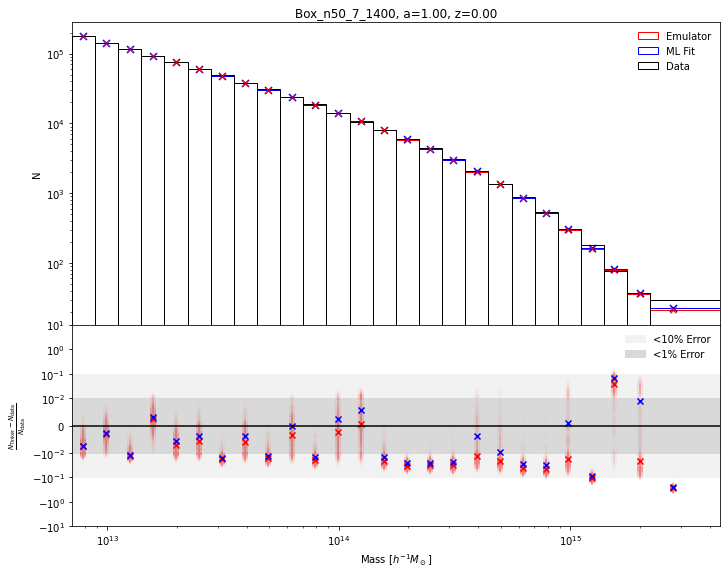

In [183]:
from multiprocessing import Pool

def estimate_uncertainty(param_combo):
    c_params = dict(zip(param_names, param_combo)) | FIXED
    tinker_eval_MCMC = [mass_function.tinker(a, M_c, c_params,)*vol for M_c in M_numerics]
    f_dndM_MCMC =  interp1d(M_numerics, tinker_eval_MCMC, kind='linear', 
                            bounds_error=False, fill_value=0.)
    tinker_eval_MCMC = np.array([quad(f_dndM_MCMC, edge[0],  edge[1], epsabs=1e-1)[0] for edge in edge_pairs])
    return tinker_eval_MCMC

for a in reversed(N_data):
    if(a != 1):
        continue
    fig1 = plt.figure(figsize =(12, 7))

    axs=[fig1.add_axes((0.2,0.4,.75,.6)), fig1.add_axes((0.2,0.0,.75,.4))]
    plt.subplots_adjust(wspace=0, hspace=0)
    Pk = mass_function.Pka[a]
    c_data = NvMs[a]

    Ms = M_data[a]
    N = N_data[a]
    edge_pairs = c_data['edge_pairs']

    edges = [edge[0] for edge in edge_pairs]
    edges += [edge_pairs[-1][1]]

    #shade in 1% and 10% error region
    edges = np.array(edges)

    y1 = 0.1*np.ones_like(N)
    y1 = np.append(y1, y1[-1])
    y1 = np.append(y1[0], y1)

    y2 = -0.1*np.ones_like(N)
    y2 = np.append(y2, y2[-1])
    y2 = np.append(y2[0], y2)

    c_Ms = np.append(Ms, edges[-1])
    c_Ms = np.append(edges[0], c_Ms)
    axs[1].fill_between(c_Ms, y1, y2, alpha=1, color='0.95',label='<10% Error')

    y1 = 0.01*np.ones_like(N)
    y1 = np.append(y1, y1[-1])
    y1 = np.append(y1[0], y1)

    y2 = -0.01*np.ones_like(N)
    y2 = np.append(y2, y2[-1])
    y2 = np.append(y2[0], y2)

    axs[1].fill_between(c_Ms, y1, y2, alpha=1, color='0.85',label='<1% Error')


    dM = np.array([edges[1]-edges[0] for edges in edge_pairs])

    

    #get uncertainty in emulator prediction
    pool = Pool()
    uncertainty_estimate = list(tqdm(pool.imap(estimate_uncertainty, samples[box]), 
                                     total=len(samples[box])))    
    emulator_uncertainty = np.std(uncertainty_estimate, axis=0)
    
    for sample_param in tqdm(samples[box]):
        c_params = dict(zip(param_names, sample_param)) | FIXED
        tinker_eval_MCMC = [mass_function.tinker(a, M_c, c_params,)*vol for M_c in M_numerics]
        f_dndM_MCMC =  interp1d(M_numerics, tinker_eval_MCMC, kind='linear', 
                                bounds_error=False, fill_value=0.)
        tinker_eval_MCMC = np.array([quad(f_dndM_MCMC, edge[0],  edge[1], epsabs=1e-1)[0] for edge in edge_pairs])
        axs[1].scatter(Ms, (tinker_eval_MCMC-N)/N, color='lightcoral', alpha=0.01, marker='+') 



    #Emulator 
    c_params = dict(zip(param_names, mean[box])) | FIXED
    tinker_eval_MCMC = [mass_function.tinker(a, M_c, c_params,)*vol for M_c in M_numerics]
    f_dndM_MCMC =  interp1d(M_numerics, tinker_eval_MCMC, kind='linear', 
                            bounds_error=False, fill_value=0.)
    tinker_eval_MCMC = np.array([quad(f_dndM_MCMC, edge[0],  edge[1], epsabs=1e-1)[0] for edge in edge_pairs])
    axs[0].errorbar(Ms, tinker_eval_MCMC, emulator_uncertainty, fmt='x', c='red')
    axs[0].bar(x=edges[:-1], height=tinker_eval_MCMC, width=np.diff(edges), 
               align='edge', fill=False, ec='red', label='Emulator')
#     axs[1].errorbarr(Ms, (tinker_eval_MCMC-N)/N, emulator_uncertainty/N, fmt='x', color='red')
    axs[1].scatter(Ms, (tinker_eval_MCMC-N)/N, marker='x', color='red')

    #ML Fit
    params = None
    if(box in box_test):
        params = Y_test[np.where(box_test==box)][0]
    elif(box in box_train):
        params = Y_train[np.where(box_train==box)][0]

    c_params = dict(zip(param_names, params)) | FIXED
    tinker_eval_MCMC = [mass_function.tinker(a, M_c, c_params,)*vol for M_c in M_numerics]
    f_dndM_MCMC =  interp1d(M_numerics, tinker_eval_MCMC, kind='linear', 
                            bounds_error=False, fill_value=0.)
    tinker_eval_MCMC = np.array([quad(f_dndM_MCMC, edge[0],  edge[1], epsabs=1e-1)[0] for edge in edge_pairs])
    axs[0].scatter(Ms, tinker_eval_MCMC, s=50 , marker='x', c='blue')
    axs[0].bar(x=edges[:-1], height=tinker_eval_MCMC, width=np.diff(edges), 
               align='edge', fill=False, ec='blue', label='ML Fit')
    axs[1].scatter(Ms, (tinker_eval_MCMC-N)/N, marker='x', color='blue')

    #Data
    axs[0].bar(x=edges[:-1], height=N, width=np.diff(edges),
           align='edge', fill=False, ec='black', label='Data')

    axs[0].set_xscale('log')
    axs[0].set_yscale('log')
    axs[0].legend(frameon=False)
    axs[0].set_ylabel('N')

    axs[1].set_xscale('log')
    axs[1].set_yscale('symlog', linthresh=1e-2)    
    axs[1].legend(frameon=False)
    axs[1].axhline(0, c='black')
    axs[1].set_ylabel('N')
    axs[1].set_xlabel(r'Mass $[h^{-1}M_\odot]$')
    axs[1].set_ylabel(r'$\frac{N_{\rm Tinker}-N_{\rm data}}{N_{\rm data}} $')
    axs[0].set_title('%s, a=%.2f, z=%.2f'%(box, a, scaleToRedshift(a)))
    i+=1

    axs[0].set_xlim((200*Mpart, np.max(edges)))
    axs[1].set_xlim((200*Mpart, np.max(edges)))
    axs[1].set_ylim((-1e1, 1e1))
    plt.savefig('/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/figures/%s_emufit_%.2f.pdf'%(box, a), bbox_inches='tight')